In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../../')])

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Recovering the result of Hamilton et al. (2023)

In this example, we recover results similar to what was shown in

* TBD

obtained with a 2-layer channel QG atmosphere truncated at wavenumber 2 coupled, both by friction and heat exchange, to a shallow water ocean with 8 modes, and with a dynamic reference temperature for both components. 


## Modules import

Loading of some modules...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(210217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies

and diagnostics

In [7]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

## Systems definition

General parameters

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 100

number_of_trajectories = 1

Setting some model parameters

In [9]:
# Model parameters instantiation with some non-default specs
# Dynamic temperature is activated here with the dynamic_T parameter
# Set also the T4 parameter to true to active the quartic temperature scheme as well
model_parameters = QgParams({'n': 1.5}, dynamic_T=True)
# model_parameters = QgParams({'n': 1.5}, T4=True)

# Modes definition: with dynamic reference temperature, the user has to use the symbolic modes
# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2, mode="symbolic")
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4, mode="symbolic")

In [10]:
# Setting MAOOAM parameters according to the publication linked above
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'r': 1.e-7,
                             'h': 136.5, 'd': 1.1e-7})
model_parameters.atemperature_params.set_params({'eps': 0.7, 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [11]:
model_parameters.atemperature_params.set_insolation(103., 0)
model_parameters.atemperature_params.set_insolation(103., 1)
model_parameters.gotemperature_params.set_insolation(310., 0)
model_parameters.gotemperature_params.set_insolation(310., 1)

Printing the model's parameters

In [12]:
model_parameters.print_params()

Qgs v1.0.0 parameters summary

General Parameters:
'dynamic_T': True,
'T4': False,
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.029  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.029  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 103.0  [W][m^-2]  (spectral component 1

Creating the tendencies function

In [13]:
f, Df = create_tendencies(model_parameters)

## Time integration and plotting a section of the attractor

Defining an integrator

In [14]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors (may take several minutes)

In [15]:
## Might take several minutes, depending on your cpu computational power.
ic = np.random.rand(model_parameters.ndim)*0.01
ic[29] = 3.  # Setting reasonable initial reference temperature
ic[10] = 1.5
integrator.integrate(0., 2000000.1, dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

Now integrate to obtain a trajectory on the attractor

In [16]:
integrator.integrate(0., 3000000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()

and plot $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\delta T_{{\rm o}, 2}$

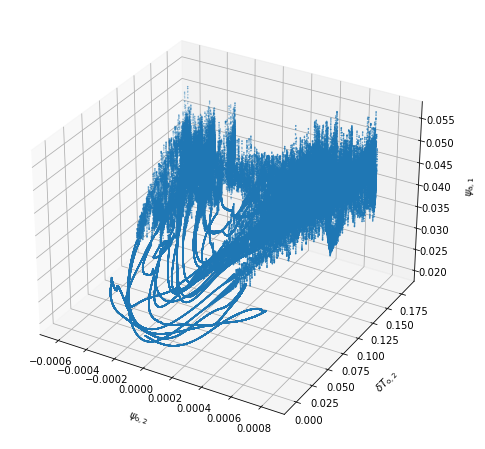

In [17]:
varx = 22
vary = 31
varz = 0

fig = plt.figure(figsize=(10, 8))
axi = fig.add_subplot(111, projection='3d')

axi.scatter(reference_traj[varx], reference_traj[vary], reference_traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$', labelpad=12.)
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$', labelpad=12.)
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$', labelpad=12.);

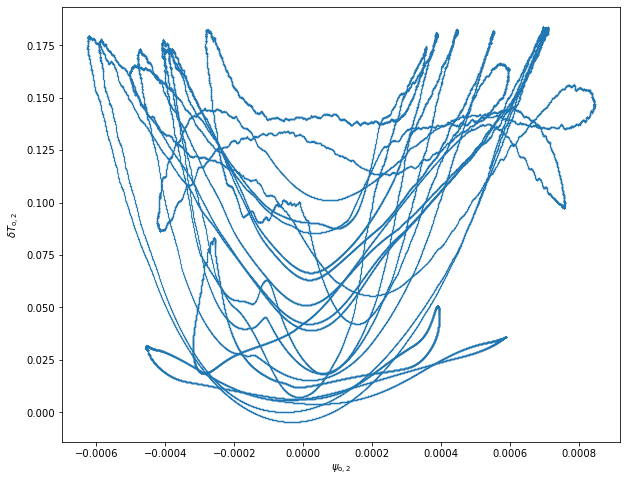

In [18]:
varx = 22
vary = 31
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

Plot of the atmospheric and oceanic reference temperatures $T_{{\rm a}, 0}$ and $T_{{\rm o}, 0}$

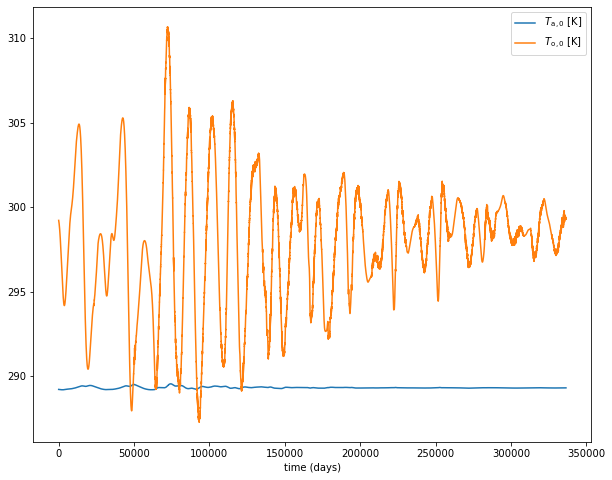

In [19]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, 2* model_parameters.temperature_scaling * reference_traj[var], label='$'+model_parameters.latex_var_string[var]+'$ [K]')
plt.plot(model_parameters.dimensional_time*reference_time, model_parameters.temperature_scaling * reference_traj[29], label='$'+model_parameters.latex_var_string[29]+'$ [K]')


plt.xlabel('time (days)')
#plt.ylabel();
plt.legend();

Plot of the low-frequency variability in $\psi_{{\rm o}, 2}$

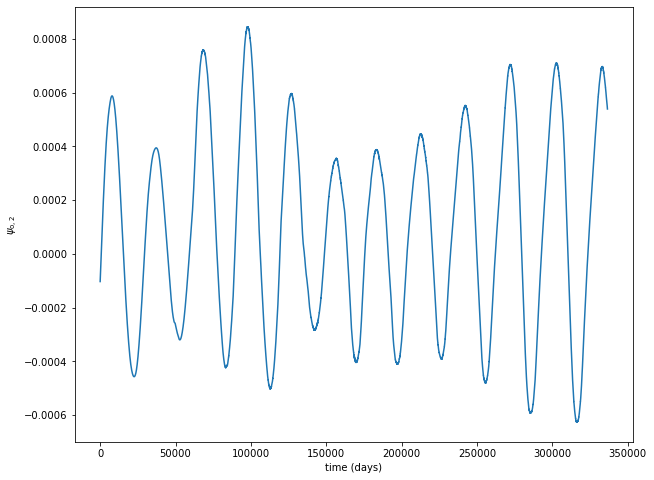

In [20]:
var = 22
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])


plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');